In [18]:
%pip install -r req.txt

Note: you may need to restart the kernel to use updated packages.


# Imports 

In [19]:
# core libraries
import pandas as pd 
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# preprocessing
from sklearn.model_selection import train_test_split

# metrics 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F

# Data Preprocessing

In [20]:
file = "datasets/meta_model_input.csv"
df = pd.read_csv(file)

# Visualize dataset
---
- visualizes sample of first 100 predictions and true angles

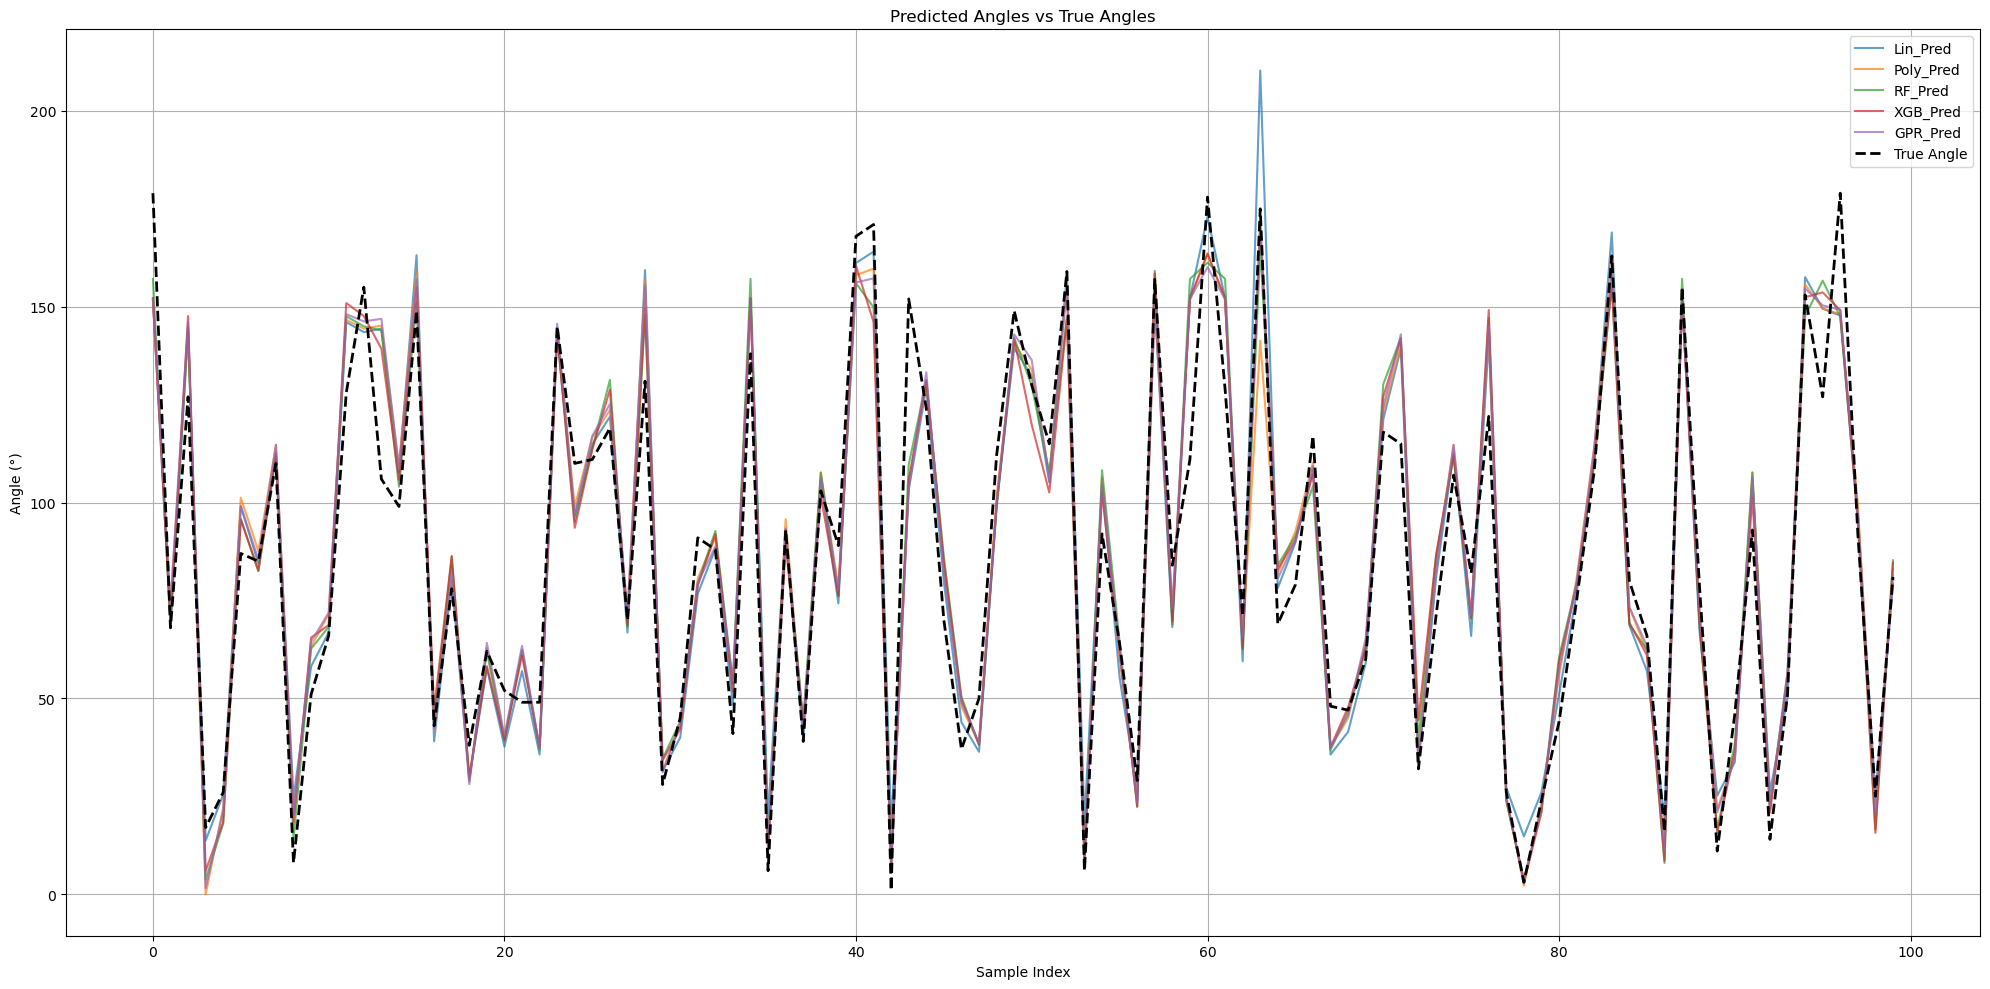

In [21]:
sample_df = df.iloc[:100]  # first 100 rows
plt.figure(figsize=(20, 10))

# Plot each prediction column
for col in sample_df.columns:
    if col.endswith("Pred"):
        plt.plot(sample_df.index, sample_df[col], label=col, alpha=0.7)

# Plot the true angles
plt.plot(sample_df.index, sample_df["True_Angle"], label="True Angle", color="black", linewidth=2, linestyle='--')
plt.xlabel("Sample Index")
plt.ylabel("Angle (°)")
plt.title("Predicted Angles vs True Angles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

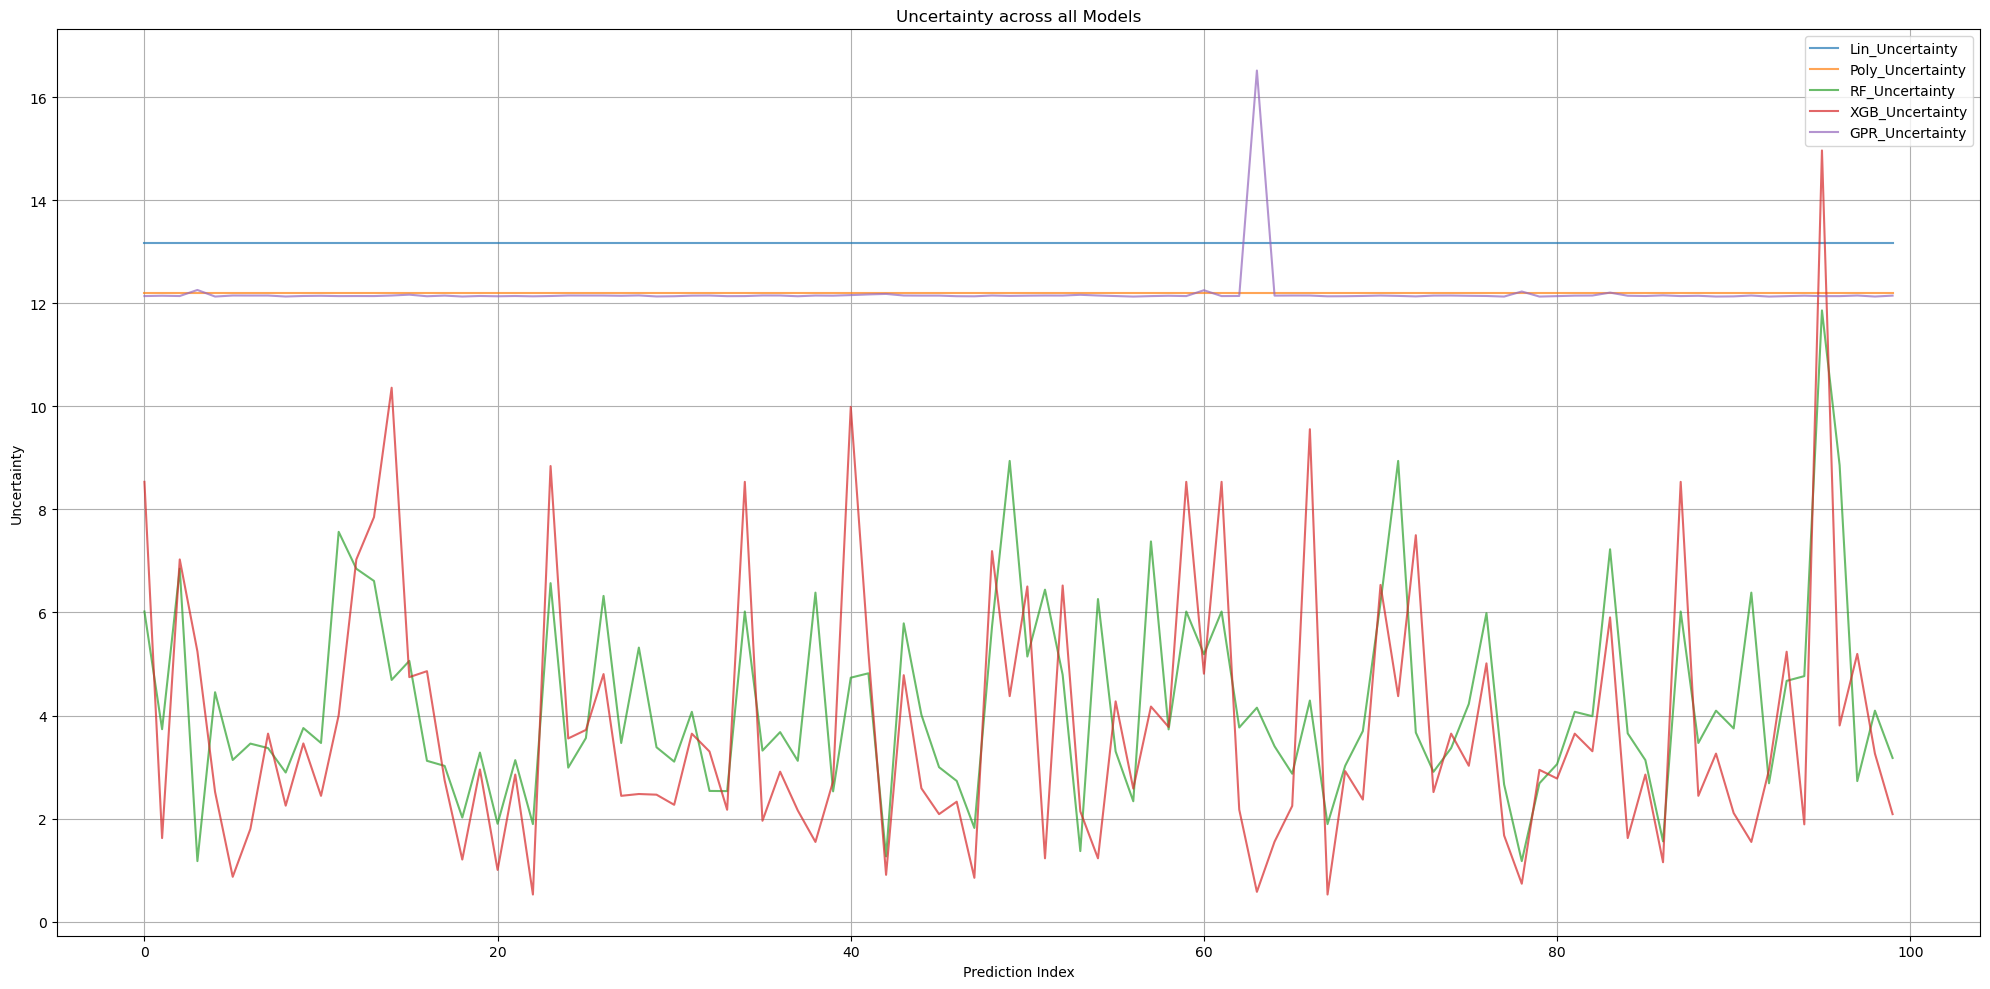

In [22]:
sample_df = df.iloc[:100]  # first 100 rows
plt.figure(figsize=(20, 10))

# Plot each prediction column
for col in sample_df.columns:
    if col.endswith("Uncertainty"):
        plt.plot(sample_df.index, sample_df[col], label=col, alpha=0.7)

# Plot the uncertainty values
plt.xlabel("Prediction Index")
plt.ylabel("Uncertainty")
plt.title("Uncertainty across all Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Min-Max Normalize Uncertainty Values (roughly between 0-1)

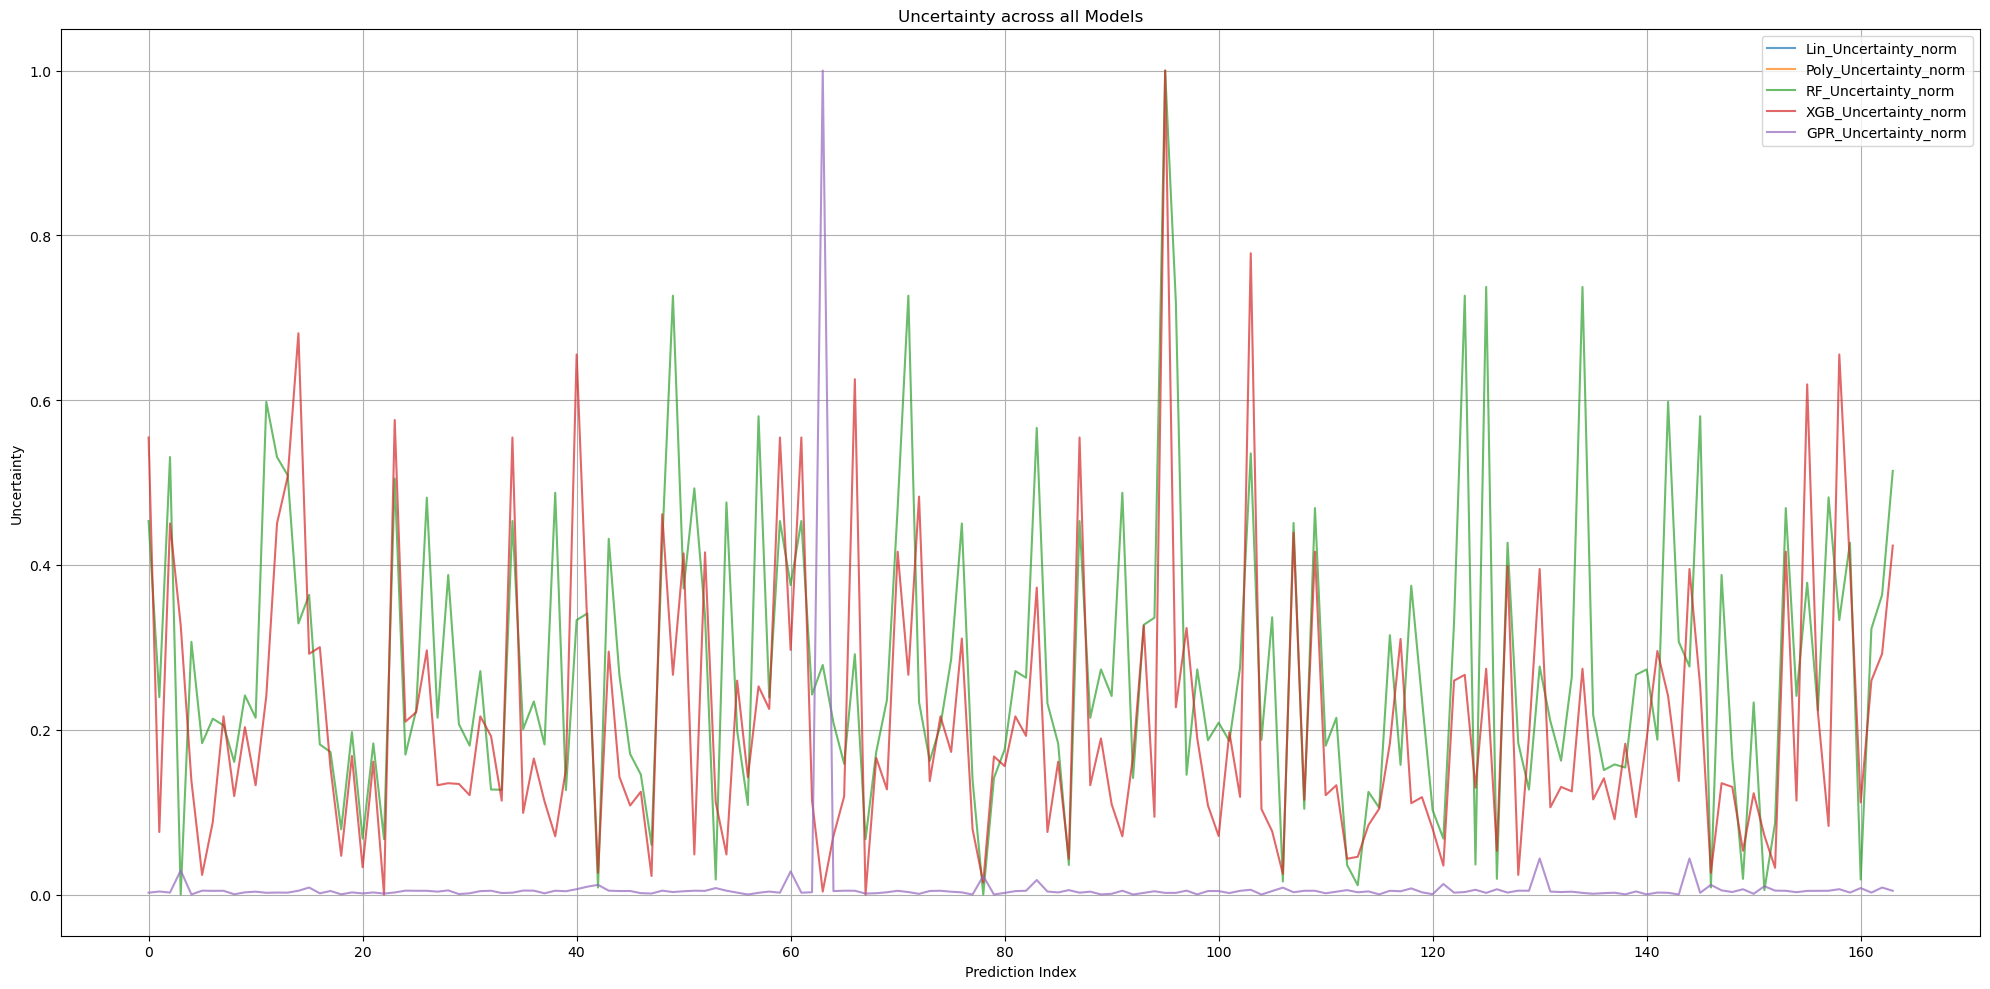

In [23]:
plt.figure(figsize=(20, 10))

# Add column of normalized uncertainity values
for col in df.columns:
    if col.endswith('Uncertainty'):
        df[f'{col}_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

for col in df.columns:
    if col.endswith('_norm'):
         plt.plot(df.index, df[col], label=col, alpha=0.7)

# Plot the true angles
plt.xlabel("Prediction Index")
plt.ylabel("Uncertainty")
plt.title("Uncertainty across all Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensemble Class

In [24]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import warnings

# # Load meta-data (predictions + uncertainties)
# csv_path = "datasets/meta_model_input.csv"
# df = pd.read_csv(csv_path)

# # Declare the model prefixes exactly as they appear in the header
# models     = ["Lin", "Poly", "RF", "XGB", "GPR"]
# pred_cols  = [f"{m}_Pred"        for m in models]
# unc_cols   = [f"{m}_Uncertainty" for m in models]

# # Normalise each uncertainty column to [0, 1]  
# unc            = df[unc_cols].astype(float)
# range_per_col  = unc.max() - unc.min()
# range_per_col  = range_per_col.replace(0, 1e-12)     # ε to stop divide-by-zero
# norm_unc       = (unc - unc.min()) / range_per_col

# # Re-normalise row-wise so weights sum to 1
# weights = 1 - norm_unc
# weights = weights.where(np.isfinite(weights), 0)     # if any inf/NaN slipped through
# row_sums = weights.sum(axis=1)

# # Where the row sum is 0 (all NaN), leave weights as NaN so we can drop that row later
# weights = weights.div(row_sums.replace(0, np.nan), axis=0)

# df["Fusion_Pred"] = (df[pred_cols] * weights).sum(axis=1)

# df_clean = df.dropna(subset=pred_cols + unc_cols + ["Fusion_Pred", "True_Angle"])

# # Evaluation 
# def metrics(y_true, y_pred):
#     mae = mean_absolute_error(y_true, y_pred)

#     with warnings.catch_warnings():
#         warnings.filterwarnings(
#             "ignore",
#             category=FutureWarning,
#             message=".*'squared' is deprecated.*"
#         )
#         rmse = mean_squared_error(y_true, y_pred, squared=False)

#     r2  = r2_score(y_true, y_pred)
#     return f"MAE {mae:6.3f}°   RMSE {rmse:6.3f}°   R² {r2:6.4f}"

# y_true = df_clean["True_Angle"]

# print("============================================")
# print(" Performance of each individual model")
# print("============================================")
# for m in models:
#     print(f"{m:4s} → {metrics(y_true, df_clean[f'{m}_Pred'])}")

# print("============================================")
# print(" Fusion (uncertainty-weighted ensemble)")
# print("============================================")
# print(metrics(y_true, df_clean["Fusion_Pred"]))

# # save cleaned dataframe
# df_clean.to_csv("meta_with_fusion.csv", index=False)
# print("\nSaved cleaned & fused data  ➜  meta_with_fusion.csv")


In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

def fuse_predictions(df: pd.DataFrame, verbose: bool = True):

    # Identify valid models with non-constant uncertainty
    models = [col.split("_")[0] for col in df.columns if col.endswith("_Uncertainty")]
    valid_models = []
    for m in models:
        unc_col = f"{m}_Uncertainty"
        if df[unc_col].max() != df[unc_col].min():
            valid_models.append(m)

    if verbose:
        print("Valid models for fusion:", valid_models)

    if len(valid_models) < 2:
        raise ValueError("Too few valid models with usable uncertainty for fusion.")

    # Prepare prediction and uncertainty matrices
    pred_cols = [f"{m}_Pred" for m in valid_models]
    unc_cols  = [f"{m}_Uncertainty" for m in valid_models]

    preds = df[pred_cols].astype(float)
    uncs  = df[unc_cols].astype(float)

    # Min-max normalisation of uncertainty (safe)
    unc_range = (uncs.max() - uncs.min()).replace(0, 1e-12)
    norm_unc = (uncs - uncs.min()) / unc_range

    # Convert to weights:  weight = 1 – norm_unc
    weights = 1.0 - norm_unc
    weights = weights.where(np.isfinite(weights), 0.0)

    row_sums = weights.sum(axis=1).replace(0, np.nan)
    weights = weights.div(row_sums, axis=0)

    # Fusion prediction
    df["Fusion_Pred"] = (preds * weights).sum(axis=1)

    # Drop any rows with NaN in fused result or truth
    df_clean = df.dropna(subset=["Fusion_Pred", "True_Angle"] + pred_cols)

    # Metric report
    def metrics(y_true, y_pred):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", FutureWarning)
            mae = mean_absolute_error(y_true, y_pred)
            rmse = mean_squared_error(y_true, y_pred, squared=False)
            r2   = r2_score(y_true, y_pred)
        return f"MAE {mae:.2f}°, RMSE {rmse:.2f}°, R² = {r2:.4f}"

    if verbose:
        print("\nModel Performance:")
        for m in valid_models:
            print(f"{m:5s} → {metrics(df_clean['True_Angle'], df_clean[f'{m}_Pred'])}")
        print("\nFusion →", metrics(df_clean["True_Angle"], df_clean["Fusion_Pred"]))

    return df_clean

In [27]:
import pandas as pd

# Load your data
df = pd.read_csv("datasets/meta_model_input.csv")  # update path if needed

# Fuse predictions (prints summary + returns new DataFrame)
from fusion_script import fuse_predictions   # or define inline
df_fused = fuse_predictions(df)

# Show result
print("\nSample output:")
print(df_fused[["Fusion_Pred", "True_Angle"]].head())


ModuleNotFoundError: No module named 'fusion_script'